In [ ]:
%pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 5.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/MyDrive/Anjali")

In [ ]:
%pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=74a5ba52fc948a2e6703231590615165b0765c6817ca0a8f8661589e45ce9526
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
import math
import random
import numpy as np
import json
import torch
import lime
import lime.lime_text
from torch import nn
from collections import defaultdict
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer, InputExample, losses, models, evaluation
from sentence_transformers.evaluation import TripletEvaluator
from sklearn.metrics import f1_score

In [ ]:
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Device: mps")
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Device: cuda")
else:
    device = torch.device('cpu')
    print("Device: cpu")

Device: cuda


In [ ]:
file_path_train = 'scicite/train.jsonl'
file_path_dev = 'scicite/dev.jsonl'
file_path_test = 'scicite/test.jsonl'
train_data = []
dev_data = []
test_data = []
with open(file_path_train, 'r', encoding='utf-8') as file:
    for line in file:
        train_data.append(json.loads(line))
with open(file_path_dev, 'r', encoding='utf-8') as file:
    for line in file:
        dev_data.append(json.loads(line))
with open(file_path_test, 'r', encoding='utf-8') as file:
    for line in file:
        test_data.append(json.loads(line))
print("Sample data points:")
print(train_data[0])
print(train_data[1])
print(train_data[2])
print("Keys:", list(train_data[0].keys()))
print("Number of training data points:", len(train_data))
print("Label distribution:", {x['label']: sum([1 for y in train_data if y['label'] == x['label']]) for x in train_data[:100]})

Sample data points:
{'source': 'explicit', 'citeEnd': 175, 'sectionName': 'Introduction', 'citeStart': 168, 'string': 'However, how frataxin interacts with the Fe-S cluster biosynthesis components remains unclear as direct one-to-one interactions with each component were reported (IscS [12,22], IscU/Isu1 [6,11,16] or ISD11/Isd11 [14,15]).', 'label': 'background', 'label_confidence': 1.0, 'citingPaperId': '1872080baa7d30ec8fb87be9a65358cd3a7fb649', 'citedPaperId': '894be9b4ea46a5c422e81ef3c241072d4c73fdc0', 'isKeyCitation': True, 'id': '1872080baa7d30ec8fb87be9a65358cd3a7fb649>894be9b4ea46a5c422e81ef3c241072d4c73fdc0', 'unique_id': '1872080baa7d30ec8fb87be9a65358cd3a7fb649>894be9b4ea46a5c422e81ef3c241072d4c73fdc0_11', 'excerpt_index': 11}
{'source': 'explicit', 'citeStart': 16, 'sectionName': 'Novel Quantitative Trait Loci for Seminal Root Traits in Barley', 'string': 'In the study by Hickey et al. (2012), spikes were sampled from the field at the point of physiological\nrobinson et al.

In [ ]:
for data_point in train_data[:10]:
    print("Citation Text:", data_point['string'])
    print("Label:", data_point['label'])
    print("Label Confidence:", data_point['label_confidence'])

Citation Text: However, how frataxin interacts with the Fe-S cluster biosynthesis components remains unclear as direct one-to-one interactions with each component were reported (IscS [12,22], IscU/Isu1 [6,11,16] or ISD11/Isd11 [14,15]).
Label: background
Label Confidence: 1.0
Citation Text: In the study by Hickey et al. (2012), spikes were sampled from the field at the point of physiological
robinson et al.: genomic regions influencing root traits in barley 11 of 13
maturity, dried, grain threshed by hand, and stored at −20C to preserve grain dormancy before germination testing.
Label: background
Label Confidence: 1.0
Citation Text: The drug also reduces catecholamine secretion, thereby reducing stress and leading to a modest (10-20%) reduction in heart rate and blood pressure, which may be particularly beneficial in patients with cardiovascular disease.(7) Unlike midazolam, dexmedetomidine does not affect the ventilatory response to carbon dioxide.
Label: background
Label Confidence: 

In [ ]:
# Use SciBERT for mapping text to embeddings
model_name = 'allenai/scibert_scivocab_uncased'
word_embedding_model = models.Transformer(model_name)

# Apply mean pooling to get one fixed sized sentence vector
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),
                               pooling_mode_mean_tokens=True,
                               pooling_mode_cls_token=False,
                               pooling_mode_max_tokens=False)

model = SentenceTransformer(modules=[word_embedding_model, pooling_model], device=device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/228k [00:00<?, ?B/s]

In [ ]:
class CitationsDataset:
    label_to_id = {'background': 0, 'method': 1, 'result': 2}
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, item):
        return InputExample(guid=item, texts=[self.data[item]['string']], label=CitationsDataset.label_to_id[self.data[item]['label']])

In [ ]:
# Parameters
train_batch_size = 16
dev_batch_size = train_batch_size
test_batch_size = train_batch_size
num_epochs = 5

In [ ]:
train_dataset = CitationsDataset(train_data)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=train_batch_size)

In [ ]:
def triplets_from_labeled_dataset(input_examples):
    # Create triplets for a [(label, sentence), (label, sentence)...] dataset
    # by using each example as an anchor and selecting randomly a
    # positive instance with the same label and a negative instance with a different label
    triplets = []
    label2sentence = defaultdict(list)
    for inp_example in input_examples:
        label2sentence[inp_example.label].append(inp_example)

    for inp_example in input_examples:
        anchor = inp_example

        if len(label2sentence[inp_example.label]) < 2:  # We need at least 2 examples per label to create a triplet
            continue

        positive = None
        while positive is None or positive.guid == anchor.guid:
            positive = random.choice(label2sentence[inp_example.label])

        negative = None
        while negative is None or negative.label == anchor.label:
            negative = random.choice(input_examples)

        triplets.append(InputExample(texts=[anchor.texts[0], positive.texts[0], negative.texts[0]]))

    return triplets

In [ ]:
dev_dataset = CitationsDataset(dev_data)
dev_dataloader = DataLoader(dev_dataset, shuffle=False, batch_size=dev_batch_size)
dev_triplets = triplets_from_labeled_dataset(dev_dataset)

In [ ]:
train_loss = losses.BatchAllTripletLoss(model=model)
dev_evaluator = TripletEvaluator.from_input_examples(dev_triplets, name="scibert-dev-triplets")
warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1)

In [ ]:
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    evaluator=dev_evaluator,
    epochs=num_epochs,
    evaluation_steps=1000,
    warmup_steps=warmup_steps,
    output_path='output/pre_trained_scibert-scicite-2'
)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/516 [00:00<?, ?it/s]

Iteration:   0%|          | 0/516 [00:00<?, ?it/s]

Iteration:   0%|          | 0/516 [00:00<?, ?it/s]

Iteration:   0%|          | 0/516 [00:00<?, ?it/s]

Iteration:   0%|          | 0/516 [00:00<?, ?it/s]

In [ ]:
# Sanity check pretraining results
model = SentenceTransformer('output/pre_trained_scibert-scicite-2')

sentences = [
    "This framework generates embeddings for each input sentence",
    "Sentences are passed as a list of strings.",
    "The quick brown fox jumps over the lazy dog.",
]

embeddings = model.encode(sentences)

for sentence, embedding in zip(sentences, embeddings):
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")

Sentence: This framework generates embeddings for each input sentence
Embedding: [ 2.47631267e-01 -5.02545059e-01  1.09360637e-02  5.02323985e-01
  4.49392706e-01 -1.13042855e+00  2.26908118e-01  6.29938006e-01
  1.02951869e-01 -6.63877010e-01  3.53772461e-01  1.01593602e+00
 -6.66331470e-01 -9.61035490e-02 -8.34647417e-02 -8.42168927e-01
  4.47839648e-01 -3.83489907e-01  9.89758313e-01  7.25656822e-02
 -2.55353689e-01 -1.82603732e-01 -4.33289707e-01 -1.60128728e-01
  1.18922138e+00 -3.02715059e-02  2.75762647e-01  9.02910590e-01
 -4.89396572e-01  2.93470562e-01 -5.17963111e-01 -5.50339818e-01
 -4.45181847e-01 -5.33200622e-01  4.20284897e-01  4.68381464e-01
  3.20847124e-01 -9.41391766e-01 -1.23456761e-01 -1.04221590e-02
 -7.10140407e-01 -1.95632607e-01  1.26438713e+00 -7.31067300e-01
  7.40858734e-01  2.92338073e-01  7.81912148e-01  2.87275076e-01
 -1.33282411e+00 -6.49645150e-01  1.06498814e+00 -7.32611954e-01
 -2.25809366e-01  7.95631647e-01 -1.17802441e-01  2.95904011e-01
 -5.06996

In [ ]:
class CitationIntentClassifier(nn.Module):
    def __init__(self, model_path, num_labels):
        super(CitationIntentClassifier, self).__init__()
        self.sentence_transformer = SentenceTransformer(model_path)
        self.classifier = nn.Linear(self.sentence_transformer.get_sentence_embedding_dimension(), num_labels)

    def forward(self, input_texts):
        embeddings = self.sentence_transformer.encode(input_texts, convert_to_tensor=True)
        return self.classifier(embeddings)

In [ ]:
model_path = 'output/pre_trained_scibert-scicite-2'
num_labels = len(CitationsDataset.label_to_id)
citation_intent_classifier = CitationIntentClassifier(model_path, num_labels).to(device)

In [ ]:
# Parameters
learning_rate = 2e-5
num_epochs = 5

In [ ]:
optimizer = torch.optim.Adam(citation_intent_classifier.parameters(), lr=learning_rate)
loss_func = torch.nn.CrossEntropyLoss()

In [ ]:
class CitationsDatasetWithoutInputExample():
    label_to_id = {'background': 0, 'method': 1, 'result': 2}
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, item):
        return self.data[item]['string'], CitationsDatasetWithoutInputExample.label_to_id[self.data[item]['label']]

In [ ]:
train_dataset = CitationsDatasetWithoutInputExample(train_data)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=train_batch_size)

In [ ]:
dev_dataset = CitationsDatasetWithoutInputExample(dev_data)
dev_dataloader = DataLoader(dev_dataset, shuffle=False, batch_size=dev_batch_size)

In [ ]:
def train_epoch(model, dataloader, loss_func, optimizer):
    model.train()
    total_loss = 0
    for input_texts, labels in dataloader:
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(input_texts)
        loss = loss_func(output, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Training loss: {total_loss / len(dataloader)}")

def evaluate(model, dataloader, loss_func):
    model.eval()
    total_loss = 0
    total_correct = 0
    with torch.no_grad():
        for input_texts, labels in dataloader:
            labels = labels.to(device)
            output = model(input_texts)
            loss = loss_func(output, labels)
            total_loss += loss.item()
            total_correct += (output.argmax(1) == labels).sum().item()
    print(f"Evaluation loss: {total_loss / len(dataloader)}")
    print(f"Evaluation accuracy: {total_correct / len(dataloader.dataset)}")

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_epoch(citation_intent_classifier, train_dataloader, loss_func, optimizer)
    evaluate(citation_intent_classifier, dev_dataloader, loss_func)

Epoch 1/5
Training loss: 0.7029123457018719
Evaluation loss: 0.4927556622644951
Evaluation accuracy: 0.8624454148471615
Epoch 2/5
Training loss: 0.3629535779125931
Evaluation loss: 0.4267689685883193
Evaluation accuracy: 0.8635371179039302
Epoch 3/5
Training loss: 0.3139913995540881
Evaluation loss: 0.42135736898615445
Evaluation accuracy: 0.861353711790393
Epoch 4/5
Training loss: 0.30026865679799586
Evaluation loss: 0.4234848956352678
Evaluation accuracy: 0.861353711790393
Epoch 5/5
Training loss: 0.2947469688230014
Evaluation loss: 0.4284801926335384
Evaluation accuracy: 0.8591703056768559


In [ ]:
test_dataset = CitationsDatasetWithoutInputExample(test_data)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=test_batch_size)

In [ ]:
def test(model, dataloader, device):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for input_texts, labels in dataloader:
            labels = labels.to(device)
            output = model(input_texts)
            _, predicted_labels = torch.max(output, dim=1)
            predictions.extend(predicted_labels.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    return predictions, true_labels

predictions, true_labels = test(citation_intent_classifier, test_dataloader, device)

In [ ]:
f1 = f1_score(true_labels, predictions, average='macro')
print(f"F1 Score: {f1}")

F1 Score: 0.850081503806138


In [ ]:
torch.save(citation_intent_classifier.state_dict(), 'output/citation_intent_classifier-2.pth')

In [ ]:
%pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=df286a97ae061eff0d430d4d4f9c399b856060b00a1999c58e5db18dfef93f61
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
model_path = 'output/pre_trained_scibert-scicite-2'
num_labels = len(CitationsDataset.label_to_id)
model = CitationIntentClassifier(model_path, num_labels).to(device)

model_state_dict = torch.load('output/citation_intent_classifier-2.pth', map_location=torch.device('cpu'))
model.load_state_dict(model_state_dict)

<All keys matched successfully>

In [ ]:
import lime.lime_tabular
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import lime.lime_tabular

tensor([[-2.0847, -1.8230,  4.0336],
        [-1.8180, -1.8291,  3.2204],
        [-1.6213, -1.8966,  3.0415],
        ...,
        [-2.0722, -1.8314,  4.0716],
        [-2.1347, -1.8533,  3.9643],
        [-2.0248, -1.8917,  4.0793]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[0.0022, 0.0028, 0.9950],
        [0.0064, 0.0063, 0.9873],
        [0.0093, 0.0071, 0.9837],
        ...,
        [0.0021, 0.0027, 0.9951],
        [0.0022, 0.0030, 0.9948],
        [0.0022, 0.0025, 0.9952]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


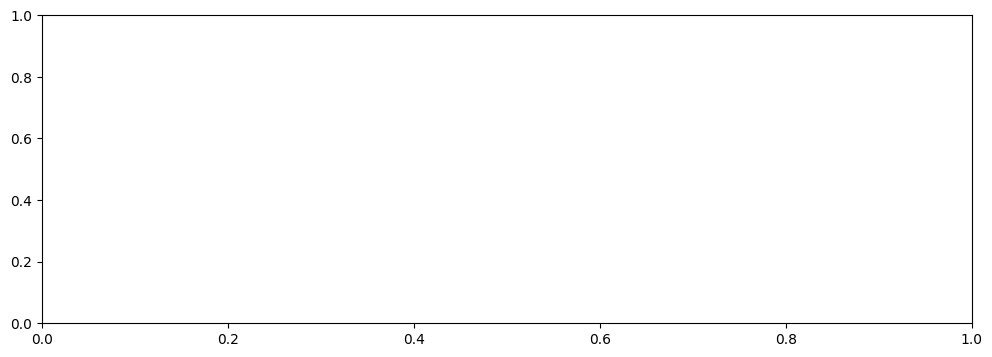

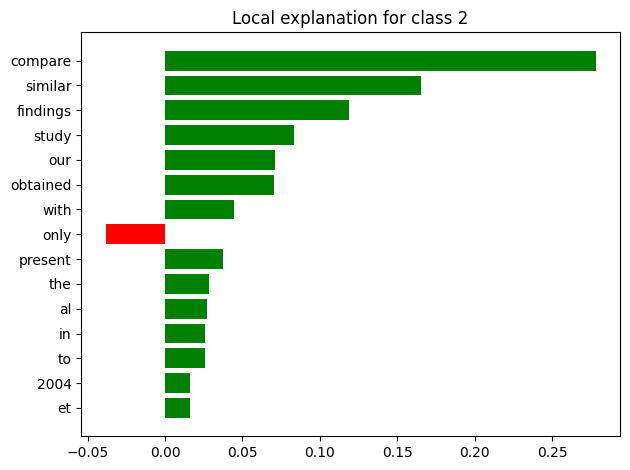

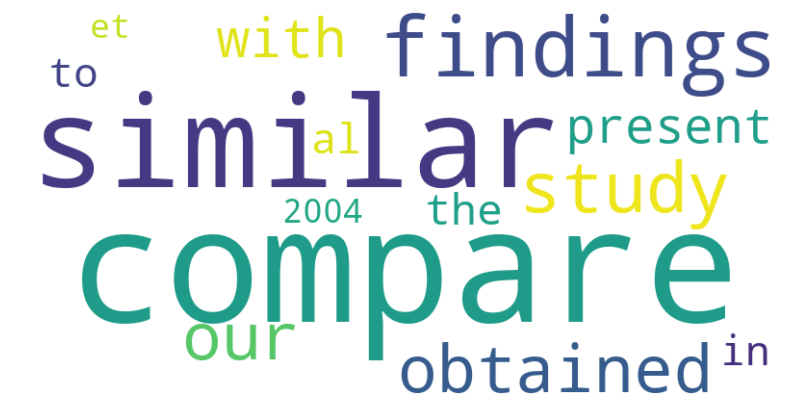

In [ ]:
text_instance = "Therefore, we can compare our findings only with the data obtained by Koubek et al. (2004) who obtained them in a way similar to the present study."

# Assume `model` is your trained model and `text_instance` is a single input text instance
explainer = lime.lime_text.LimeTextExplainer(class_names=[0, 1, 2])

def predict_proba(text):
    # Use your model to predict probabilities
    # Example:
    logits = model(text)
    print(logits)
    probabilities = torch.softmax(logits, dim=1)
    print(probabilities)
    return probabilities.detach().cpu().numpy()

# Explain prediction for a single instance
explanation = explainer.explain_instance(text_instance, predict_proba, labels=[2], num_features=15)

explanation.show_in_notebook()

def plot_feature_importance(explanation):
    # Get the available labels
    labels = explanation.available_labels()

    # Plot feature importance for each class
    fig, axs = plt.subplots(1, len(labels), figsize=(12, 4))
    if len(labels) == 1:
        axs = [axs]  # Convert to list if there's only one label

    for i, label in enumerate(labels):
        explanation.as_pyplot_figure(label=label)

    plt.tight_layout()
    plt.show()

plot_feature_importance(explanation)

def generate_wordcloud(explanation):
    # Generate word cloud based on word importance
    word_importance = {word: weight for word, weight in explanation.as_list(label=explanation.available_labels()[0])}
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_importance)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Generate word cloud
generate_wordcloud(explanation)

tensor([[-2.0847, -1.8230,  4.0336],
        [-0.9922, -0.5054, -0.3920],
        [-1.2891, -0.8629,  0.5237],
        ...,
        [-2.1882, -0.2465,  1.6463],
        [ 1.5673, -1.3293, -1.8442],
        [-2.0732, -1.9339,  4.0746]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[0.0022, 0.0028, 0.9950],
        [0.2248, 0.3657, 0.4096],
        [0.1155, 0.1769, 0.7077],
        ...,
        [0.0184, 0.1285, 0.8530],
        [0.9189, 0.0507, 0.0303],
        [0.0021, 0.0024, 0.9954]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


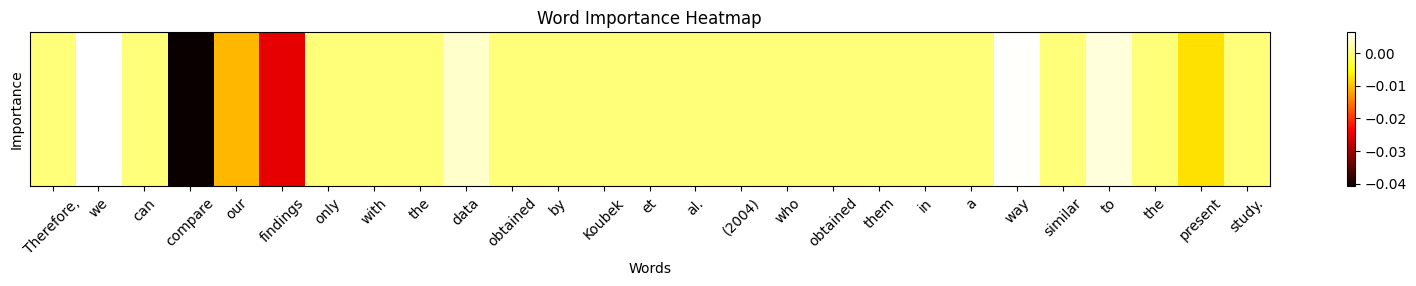

In [ ]:
explanation_without_specific_labels = explainer.explain_instance(text_instance, predict_proba)

weights = explanation_without_specific_labels.as_list()

# Convert the weights to a dictionary for easier access
word_weights = dict(weights)

# Visualize the importance of each word using a heatmap
def visualize_heatmap(word_weights, text_instance):
    words = text_instance.split()
    heatmap = np.zeros(len(words))

    for i, word in enumerate(words):
        if word in word_weights:
            heatmap[i] = word_weights[word]

    plt.figure(figsize=(20, 2))
    plt.imshow(heatmap.reshape(1, -1), cmap='hot', aspect='auto')
    plt.xticks(np.arange(len(words)), words, rotation=45)
    plt.yticks([])
    plt.xlabel('Words')
    plt.ylabel('Importance')
    plt.title('Word Importance Heatmap')
    plt.colorbar()
    plt.show()

# Generate heatmap
visualize_heatmap(word_weights, text_instance)

In [ ]:
%pip install witwidget

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 46.3 MB/s eta 0:00:00


In [ ]:
from witwidget.notebook.visualization import WitConfigBuilder
from witwidget.notebook.visualization import WitWidget

# Prepare your dataset
test_sentences = [data_point['string'] for data_point in test_data]
test_labels = [data_point['label'] for data_point in test_data]

# Function to make predictions using your model
def predict_fn(input_text):
    # Example function to make predictions using your model
    logits = model(input_text)
    probabilities = np.softmax(logits, axis=1)
    return probabilities.tolist()  # Convert predictions to list for WIT

# Generate examples for WIT
examples = [{
    'text': text,
    'label': label
} for text, label in zip(test_sentences, test_labels)]

# Configure WIT
config_builder = WitConfigBuilder(examples) \
    .set_custom_predict_fn(predict_fn) \
    .set_target_feature('label')  # Set the target feature for classification tasks

# Create the What-If Tool widget
wit_widget = WitWidget(config_builder)
wit_widget

In [ ]:
input_sentences = [data_point['string'] for data_point in train_data]
embeddings_matrix = model.sentence_transformer.encode(input_sentences, convert_to_tensor=True)

In [ ]:
import seaborn as sns

In [ ]:
embeddings_matrix = embeddings_matrix.cpu().numpy()

# Compute the correlation matrix between embedding dimensions
correlation_matrix = np.corrcoef(embeddings_matrix, rowvar=False)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".2f", xticklabels=False, yticklabels=False)
plt.title('Correlation Heatmap of Sentence Embedding Dimensions')
plt.xlabel('Embedding Dimensions')
plt.ylabel('Embedding Dimensions')
plt.show()